In [32]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler

# read datasets
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

y1_name, y2_name, y3_name = "dir_costs", "traffic_costs_s_r", "lost_trips_costs_s_r"
train_y1, train_y2, train_y3 = train_df[y1_name], train_df[y2_name], train_df[y3_name]
test_y1, test_y2, test_y3 = test_df[y1_name], test_df[y2_name], test_df[y3_name]

# scale features
X_train = train_df.drop(columns=[y1_name, y2_name, y3_name])
scaler = MaxAbsScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
# X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

X_test = test_df.drop(columns=[y1_name, y2_name, y3_name])
X_test_scaled = scaler.transform(X_test)
# X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


<h2> Figure out optimal number of clusters </h2>

<h3> Elbow method </h3>

/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416:

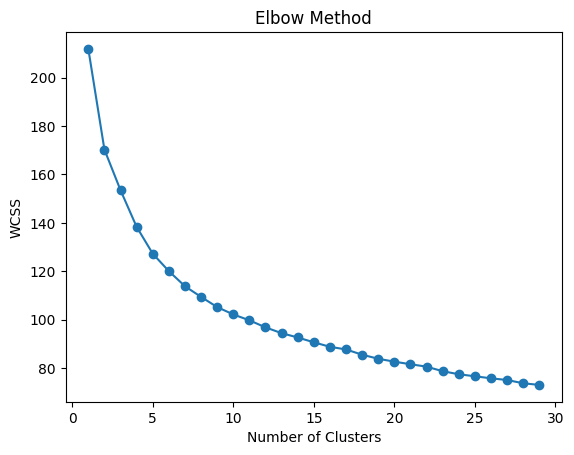

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Define a range of cluster numbers
cluster_range = range(1, 30)
wcss = []

# Calculate WCSS for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_train_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

<h3> Silhouette Method </h3>

In [ ]:
# TODO: 

In [73]:
clusters_num = 5
kmeans = KMeans(n_clusters=clusters_num, random_state=42)
kmeans.fit(X_train_scaled)

/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5, random_state=42)

In [74]:
import numpy as np
def transform_to_clustered_dataset(X: pd.DataFrame, cluster_predictor):
    clusters = cluster_predictor.predict(X)
    dummy_columns = pd.get_dummies(clusters, prefix='class').astype(float)
    return np.concatenate((X, dummy_columns), axis=1)

In [75]:
X_train_scaled_clustered = transform_to_clustered_dataset(X_train_scaled, kmeans)
X_test_scaled_clustered = transform_to_clustered_dataset(X_test_scaled, kmeans)

<h2> Pick sigma from unclustered dataset <h2>


In [76]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y1 = GRNN(sigma=0.065982729)
grnn_y1.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))
print("------ train metrics ------")
print_metrics(train_y1, grnn_y1.predict(X_train_scaled_clustered))

------ test metrics ------
Mean Squared Error (MSE):              42487957917041.1093750000
Root Mean Squared Error (RMSE):        6518278.7541682431
Mean Absolute Error (MAE):             4404426.1046991227
R-squared (R²):                        0.7792012878
Mean Absolute Percentage Error (MAPE): 0.1126095933
Max Error (ME):                        27567155.8301407397
Median Absolute Error (MedAE):         2981575.9186533988
------ train metrics ------
Mean Squared Error (MSE):              9898471755869.2148437500
Root Mean Squared Error (RMSE):        3146183.6812031833
Mean Absolute Error (MAE):             1782321.6094198860
R-squared (R²):                        0.9588310232
Mean Absolute Percentage Error (MAPE): 0.0491281209
Max Error (ME):                        23145806.6253847405
Median Absolute Error (MedAE):         880466.6676816512


<h2> Optimize sigma with differential evolution<h2>

In [77]:
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution

def objective_function(sigma):
    grnn_y1 = GRNN(sigma=sigma[0])
    grnn_y1.fit(X_train_scaled_clustered, train_y1)
    pred_y1 = grnn_y1.predict(X_test_scaled_clustered)
    r2 = r2_score(test_y1, pred_y1)
    return -r2

# differential evolution method tries to minimize objective function
def pick_optimal_sigma():
    best_sigma = differential_evolution(func=objective_function, bounds=[(0, 10)], workers=10)
    return best_sigma

In [78]:
optimization_res = pick_optimal_sigma()
print(optimization_res)
print("Optimal sigma_y1: {:.{}f}".format(optimization_res.x[0], 9))

/home/lavuna47/Projects/Diploma/venv/lib64/python3.10/site-packages/scipy/optimize/_differentialevolution.py:387: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


 message: Optimization terminated successfully.
 success: True
     fun: -0.7792185690879269
       x: [ 6.544e-02]
     nit: 14
    nfev: 233
     jac: [-1.110e-08]
Optimal sigma_y1: 0.065440175


In [79]:
from GRNN import GRNN
from metrics import print_metrics

grnn_y1 = GRNN(sigma=0.065440175)
grnn_y1.fit(X_train_scaled_clustered, train_y1)

print("------ test metrics ------")
print_metrics(test_y1, grnn_y1.predict(X_test_scaled_clustered))
print("------ train metrics ------")
print_metrics(train_y1, grnn_y1.predict(X_train_scaled_clustered))

------ test metrics ------
Mean Squared Error (MSE):              42484632506858.8437500000
Root Mean Squared Error (RMSE):        6518023.6657179175
Mean Absolute Error (MAE):             4401625.0189357614
R-squared (R²):                        0.7792185691
Mean Absolute Percentage Error (MAPE): 0.1124559028
Max Error (ME):                        27628779.4712469727
Median Absolute Error (MedAE):         2964690.3485822249
------ train metrics ------
Mean Squared Error (MSE):              9598204465154.7714843750
Root Mean Squared Error (RMSE):        3098096.9102264652
Mean Absolute Error (MAE):             1744633.9820755445
R-squared (R²):                        0.9600798722
Mean Absolute Percentage Error (MAPE): 0.0480451808
Max Error (ME):                        22949139.9491845220
Median Absolute Error (MedAE):         846677.4892855510
